In [ ]:
import numpy as np
import pandas as pd
import torch
import random

from itertools import islice, combinations, chain
from tqdm import tqdm
from collections import defaultdict, Counter
from cached_property import cached_property
from scipy import random
from sklearn import preprocessing

from news_vec.utils import read_json_gz_lines
from news_vec import logger

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
class Actors:
    
    def __init__(self, root, skim=None):
        self.root = root
        self.skim = skim
        
    def __iter__(self):
        reader = islice(read_json_gz_lines(self.root), self.skim)
        yield from tqdm(reader)

In [43]:
ac = Actors('../data/clf-actors.json/')

In [ ]:
rows = list(ac)

28007605it [01:13, 375084.36it/s]

In [5]:
ACTOR_DOMAINS = defaultdict(set)

for row in tqdm(random.sample(rows, 10000000)):
    ACTOR_DOMAINS[row['actor_id']].add(row['domain'])

10000000it [00:36, 277476.00it/s]


In [21]:
ACTOR_DOMAINS_GT2 = {aid: ds for aid, ds in ACTOR_DOMAINS.items() if len(ds) > 1}

In [22]:
DOMAIN_COUNTS = Counter(chain(*[list(ds) for ds in ACTOR_DOMAINS_GT2.values()]))

In [23]:
DOMAINS, DOMAIN_COUNTS = zip(*DOMAIN_COUNTS.most_common())

In [24]:
DOMAIN_COUNTS_PRIOR = np.array(DOMAIN_COUNTS) / np.sum(DOMAIN_COUNTS)
DOMAIN_COUNTS_PRIOR = torch.from_numpy(DOMAIN_COUNTS_PRIOR).view(1, -1)

In [25]:
DOMAINS

('cnn.com',
 'nytimes.com',
 'huffingtonpost.com',
 'foxnews.com',
 'buzzfeed.com',
 'washingtonpost.com',
 'bloomberg.com',
 'thehill.com',
 'apnews.com',
 'breitbart.com',
 'npr.org',
 'dailycaller.com',
 'dailykos.com',
 'wsj.com',
 'rt.com',
 'sputniknews.com')

In [26]:
DOMAIN_COUNTS_PRIOR

tensor([[0.1776, 0.0960, 0.0896, 0.0868, 0.0723, 0.0693, 0.0685, 0.0676, 0.0654,
         0.0537, 0.0515, 0.0436, 0.0223, 0.0214, 0.0114, 0.0028]],
       dtype=torch.float64)

In [27]:
ACTOR_NUM_DOMAINS = [len(ds) for _, ds in ACTOR_DOMAINS_GT2.items()]
NUM_DOMAINS, NUM_DOMAINS_COUNT = zip(*Counter(ACTOR_NUM_DOMAINS).most_common())

In [28]:
NUM_DOMAINS_PRIOR = np.array(NUM_DOMAINS_COUNT) / np.sum(NUM_DOMAINS_COUNT)
NUM_DOMAINS_PRIOR = torch.from_numpy(NUM_DOMAINS_PRIOR).view(1, -1)

In [29]:
NUM_DOMAINS

(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)

In [31]:
NUM_DOMAINS_PRIOR

tensor([[4.8404e-01, 1.9694e-01, 1.0600e-01, 6.4989e-02, 4.3533e-02, 3.0745e-02,
         2.2324e-02, 1.7092e-02, 1.2827e-02, 9.7293e-03, 6.7248e-03, 3.5475e-03,
         1.2346e-03, 2.2028e-04, 4.2262e-05]], dtype=torch.float64)

In [32]:
OBSERVED_DOMAIN_PAIR_COUNTS = Counter()

for _, domains in tqdm(ACTOR_DOMAINS_GT2.items()):
    for d1, d2 in combinations(domains, 2):
        OBSERVED_DOMAIN_PAIR_COUNTS[tuple(sorted([d1, d2]))] += 1

100%|██████████| 780836/780836 [00:06<00:00, 123288.96it/s]


In [33]:
SAMPLED_DOMAIN_PAIR_COUNTS = defaultdict(list)

for _ in tqdm(range(10)):
    
    # Sample actor -> domain count.
    ps = NUM_DOMAINS_PRIOR.repeat(len(ACTOR_DOMAINS_GT2), 1)
    num_domains_idxs = torch.multinomial(ps, 1)
    num_domains = [NUM_DOMAINS[i] for i in num_domains_idxs.view(-1).tolist()]
    
    counts = Counter()
    for nd, c in Counter(num_domains).items():
        
        # Sample actor -> domains.
        ps = DOMAIN_COUNTS_PRIOR.repeat(c, 1)
        domain_idxs = torch.multinomial(ps, nd)
        
        # Register counts.
        for idxs in domain_idxs.tolist():
            for i1, i2 in combinations(idxs, 2):
                key = tuple(sorted([DOMAINS[i1], DOMAINS[i2]]))
                counts[key] += 1
            
    for p, count in counts.items():
        SAMPLED_DOMAIN_PAIR_COUNTS[p].append(count)

100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


In [34]:
sum(OBSERVED_DOMAIN_PAIR_COUNTS.values())

5366867

In [35]:
sum([cs[0] for _, cs in SAMPLED_DOMAIN_PAIR_COUNTS.items()])

5382161

In [36]:
rows = []
for pair, count in OBSERVED_DOMAIN_PAIR_COUNTS.items():
    sampled_counts = SAMPLED_DOMAIN_PAIR_COUNTS[pair]
    zscore = (count - np.mean(sampled_counts)) / np.std(sampled_counts)
    rows.append((pair, zscore))

In [37]:
zdf = pd.DataFrame(rows, columns=('pair', 'zscore'))
zdf.sort_values('zscore', ascending=False, inplace=True)

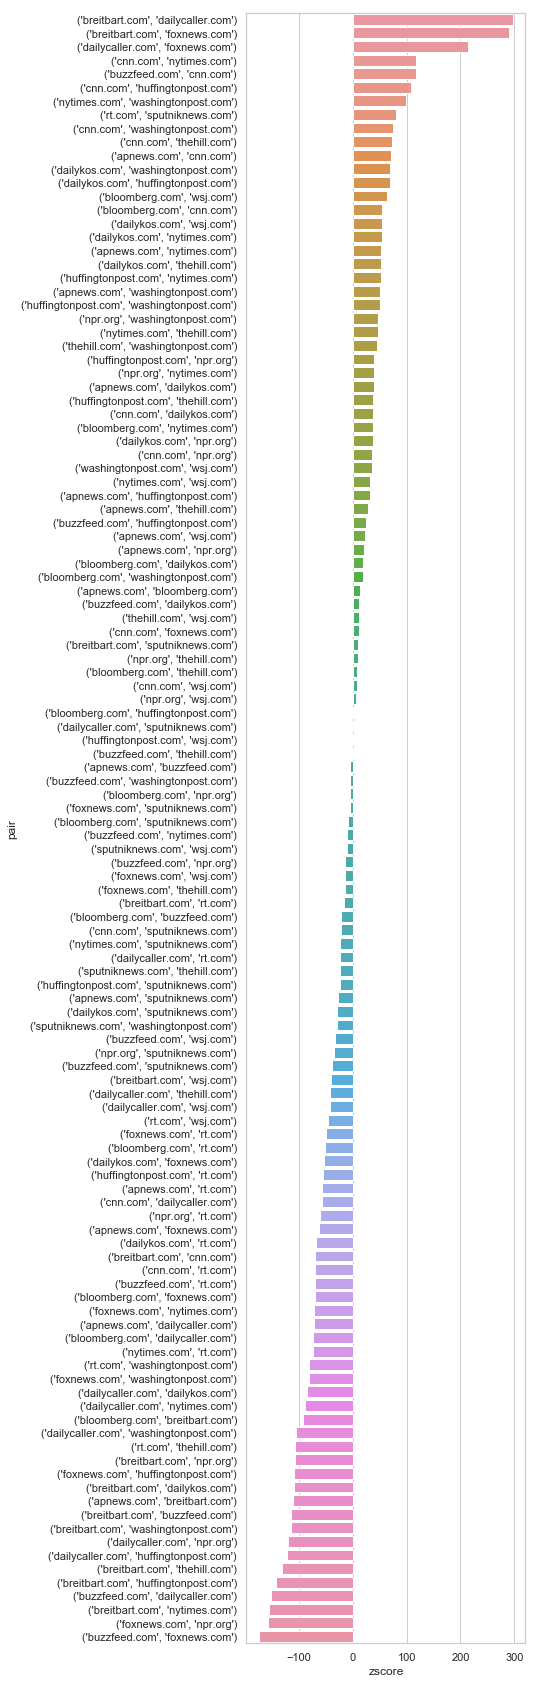

In [38]:
plt.figure(figsize=(5,30))
sns.barplot(x='zscore', y='pair', data=zdf)

In [40]:
zdf['score'] = preprocessing.scale(zdf.zscore)

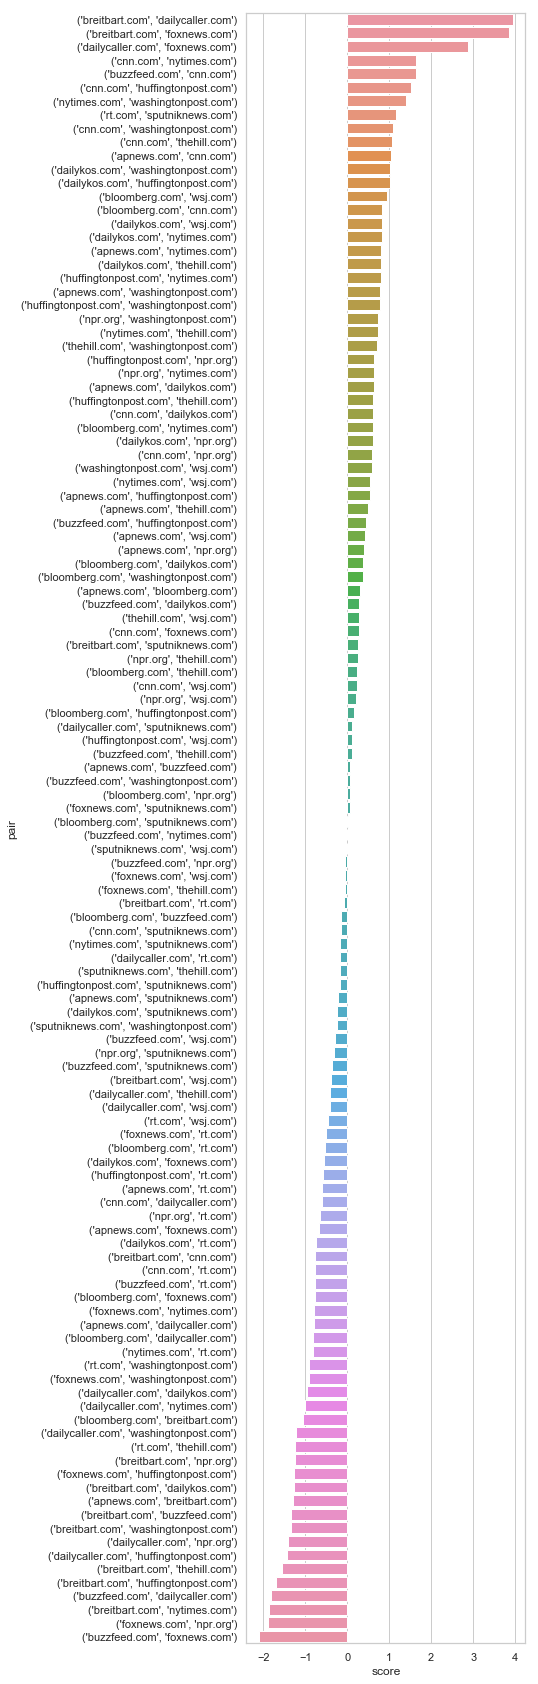

In [42]:
plt.figure(figsize=(5,30))
sns.barplot(x='score', y='pair', data=zdf)